# Convolutional Neural Network for CIFAR100

*M.Sc. Sergio Chavez Lazo*

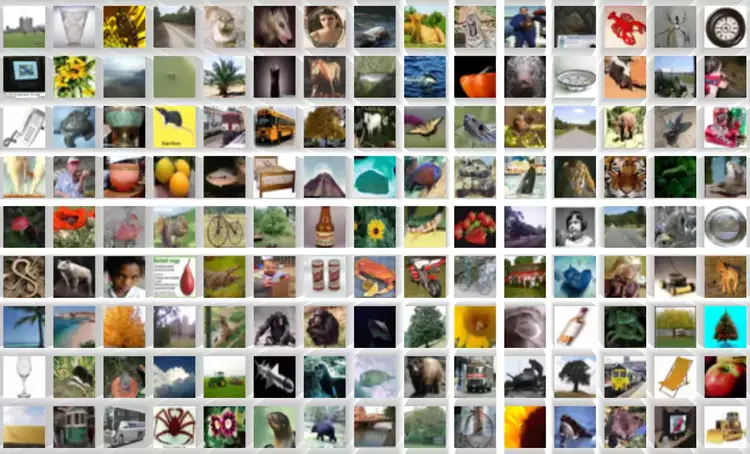

**Summary** This project presents the creation of a convolutional neural network (CNN) to classify images belonging to the CIFAR100 database. The results obtained from 7 models with progressive complexity are compared. After a process of transfer learning and two-stage optimisation of the hyperparameters in model 7, a model with an accuracy of 59.5% was built.  Although the result can still be improved, there is a significant improvement compared to the initial results with the first model - Simple Neural Network - (18.5%). Models 1 and 7 were also tested for the super classes of the database with even more significant improvements (37.7% and 65.6% respectively). 



## Preprocessing

In [1]:
#!pip install tensorflow
import os
os.environ['PYTHONHASHSEED']=str(2) #Important to set a seed for CNN
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import datasets, layers, models #The data is inside keras 
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import time
import random #To ensure reproducibility
from sklearn.metrics import classification_report
from keras import datasets
plt.rc('font', family='Times New Roman')
os.chdir('D:\\Users\\sergi\\OneDrive\\Desktop\\0. Manchester\\0. Courses\\I. 2023-1\\4. Stats\\Assignment\\cifar-100-python')

In [2]:
#Get the data
(x_train,y_train),(x_test,y_test)=datasets.cifar100.load_data()
y_train_reshaped=y_train.reshape(-1, ) #For image plotting
y_test_reshaped=y_test.reshape(-1, )

In [3]:
print('Size train: ' + str(len(x_train)) + ', Shape: ' + str(x_train.shape))
print('Size test: ' + str(len(x_test)) + ', Shape: ' + str(x_test.shape))

Size train: 50000, Shape: (50000, 32, 32, 3)
Size test: 10000, Shape: (10000, 32, 32, 3)


In [4]:
#Super labels
super_classes1={
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
    'fish': ['aquarium fish', 'flatfish', 'ray', 'shark', 'trout'],
    'flowers': ['orchids', 'poppies', 'roses', 'sunflowers', 'tulips'],
    'food containers': ['bottles', 'bowls', 'cans', 'cups', 'plates'],
    'fruit and vegetables': ['apple', 'mushroom', 'oranges', 'pears', 'sweet peppers'],
    'household electrical devices': ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
    'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
    'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
    'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
    'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
    'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
    'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
    'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
    'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
    'people': ['baby', 'boy', 'girl', 'man', 'woman'],
    'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
    'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
    'trees': ['maple', 'oak', 'palm', 'pine', 'willow'],
    'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup truck', 'train'],
    'vehicles 2': ['lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

super_classes_number={
    0: [4, 30, 55, 72, 95],
    1: [1, 32, 67, 73, 91],
    2: [54, 62, 70, 82, 92],
    3: [9, 10, 16, 28, 61],
    4: [0, 51, 53, 57, 83],
    5: [22, 39, 40, 86, 87],
    6: [5, 20, 25, 84, 94],
    7: [6, 7, 14, 18, 24],
    8: [3, 42, 43, 88, 97],
    9: [12, 17, 37, 68, 76],
    10: [23, 33, 49, 60, 71],
    11: [15, 19, 21, 31, 38],
    12: [34, 63, 64, 66, 75],
    13: [26, 45, 77, 79, 99],
    14: [2, 11, 35, 46, 98],
    15: [27, 29, 44, 78, 93],
    16: [36, 50, 65, 74, 80],
    17: [47, 52, 56, 59, 96],
    18: [8, 13, 48, 58, 90],
    19: [41, 69, 81, 85, 89]
}
#To more efficient labeling, transform the dictionary (keys become repeated values and each value a key)
super_classes2 = {item: key for key, value in super_classes1.items() for item in value} #This is a another way to say the following:
sup_class_number= {item: key for key, value in super_classes_number.items() for item in value}
#To search according to labels
super_classes2['dolphin']
sup_class_number[10]
list_superclasses=[key for key, value in super_classes1.items() ]
list_superclasses

['aquatic mammals',
 'fish',
 'flowers',
 'food containers',
 'fruit and vegetables',
 'household electrical devices',
 'household furniture',
 'insects',
 'large carnivores',
 'large man-made outdoor things',
 'large natural outdoor scenes',
 'large omnivores and herbivores',
 'medium-sized mammals',
 'non-insect invertebrates',
 'people',
 'reptiles',
 'small mammals',
 'trees',
 'vehicles 1',
 'vehicles 2']

In [5]:
#To make sure the labels match
class_list = []
for i in super_classes1.values():
    for e in i:
        class_list.append(e)
class_list.sort()

In [6]:
#Get new y's for Superclasses
#Train
y_train_sup=[]
for i in range(len(y_train)):
    for key, value in super_classes_number.items():
        for element in value:
            if y_train_reshaped[i]==element:
                y_train_sup.append(key)               
y_train_sup=np.array(y_train_sup).reshape(len(y_train), 1)
#Test
y_test_sup=[]
for i in range(len(y_test)):
    for key, value in super_classes_number.items():
        for element in value:
            if y_test_reshaped[i]==element:
                y_test_sup.append(key)               
y_test_sup=np.array(y_test_sup).reshape(len(y_test), 1)

In [7]:
#Ploting data
def plot_image(train_dataset,index):
    plt.axis('off')
    plt.title('Label: ' + str(class_list[y_train_reshaped[index]]) + '\n Superlabel: ' + str(super_classes2[class_list[y_train_reshaped[index]]]))
    plt.imshow(train_dataset[index])
    plt.tight_layout()
    plt.show()

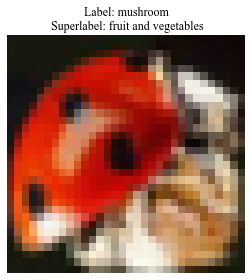

In [8]:
plot_image(x_test,64)

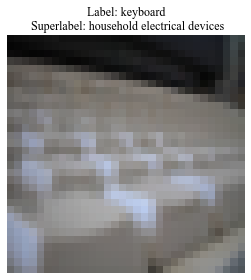

In [9]:
plot_image(x_train,80)

In [10]:
#Normalization
np.max(x_train) #255
#Lets normalize to have pixels between 0 to 1 (better for the model)
x_train=x_train/255
x_test=x_test/255

## Initial parameters and functions

In [11]:
#Basic hyperparameters (to optmize in later stages)
np.random.seed(1671)  
N_EPOCH = 50 
BATCH_SIZE = round(len(x_train)/1000) #Batch 50 for backpropagation every 1000 cases
VERBOSE = 1 
VALIDATION_SPLIT=0.2
stop_early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True,verbose=1,mode='min') 
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 5, 
                        factor = 0.5, min_lr = 1e-6, verbose = 1)

In [12]:
#Shuffle data to have balanced data
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(x_train, y_train):
    X_train, X_val, Y_train, Y_val = x_train[train_index], x_train[val_index], y_train[train_index], y_train[val_index]
    
print("The number of training data : ", X_train.shape[0])
print("The number of validation data : ", X_val.shape[0])

The number of training data :  40000
The number of validation data :  10000


In [13]:
#To ensure reproducibility
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   tf.random.set_seed(2)
   np.random.seed(2)
   random.seed(2)

##### Functions

In [14]:
#Get predictions for test
def get_predictions(model):
    predictions_model=model.predict(x_test)
    predictions_model=[np.argmax(element) for element in predictions_model]
    return predictions_model

In [15]:
#Plot test results with prediction and real value
def image_result(index,predictions_modelx):
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(x_test[index])
    plt.title('True value: ' + str(class_list[y_test_reshaped[index]]) + '\n Predicted: ' + str(class_list[predictions_modelx[index]]))
    plt.show()

In [16]:
y_test_sup_reshaped=y_test_sup.reshape(-1, )
def image_result2(index,predictions_modelx):
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(x_test[index])
    plt.title('True value: ' + str(list_superclasses[y_test_sup_reshaped[index]]) + '\n Predicted: ' + str(list_superclasses[predictions_modelx[index]]))
    plt.show()

In [17]:
#Convert loaded dictionary into dataframe
def history_transformation(dictionary_history):
    dataframe_history=pd.DataFrame(dictionary_history.history).rename({'loss': 'Train_Loss', 'accuracy': 'Train_Accuracy','val_loss':'Validation_Loss','val_accuracy':'Validation_Accuracy'}, axis=1).round(3)
    dataframe_history['Stage']=1
    return dataframe_history

In [18]:
#Plot to evaluate evolution in training
def plot_stage_accuracy(df,title):
    
    #General settings
    fig, (ax1,ax2) = plt.subplots(1,2, sharex=False, figsize=(14,4))
    fig.suptitle(title,fontsize=17)
    ax1.set_title('Loss performance')
    ax2.set_title('Accuracy performance')
    
    #Plot Loss
    ax1.plot(df['Train_Loss'])
    ax1.plot(df['Validation_Accuracy'])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(['Train', 'Validation'], loc='upper right')
    ax1.set_xlim([0, 50])
    
    
    #Plot Accuracy
    ax2.plot(df['Train_Accuracy'])
    ax2.plot(df['Validation_Accuracy'])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    ax2.set_xlim([0, 50])
    plt.tight_layout()
    plt.show()

In [19]:
#Modification for last training - Just training because we use all the data
def plot_stage_accuracy2(df,title):
    
    #General settings
    fig, (ax1,ax2) = plt.subplots(1,2, sharex=False, figsize=(14,4))
    fig.suptitle(title,fontsize=17)
    ax1.set_title('Loss performance')
    ax2.set_title('Accuracy performance')
    
    #Plot Loss
    ax1.plot(df['Train_Loss'])
    ax1.plot(df['Train_Loss'])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(['Train', 'Validation'], loc='upper right')
    ax1.set_xlim([0, 50])
    
    
    #Plot Accuracy
    ax2.plot(df['Train_Accuracy'])
    ax2.plot(df['Train_Accuracy'])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    ax2.set_xlim([0, 50])
    plt.tight_layout()
    plt.show()

In [20]:
def specific_evaluation(y_validation,final_prediction):
    df_pruebax=pd.DataFrame(classification_report(y_validation,final_prediction,output_dict=True)).drop(['accuracy', 'macro avg','weighted avg'], axis=1).transpose() #Final argument important to make it compatible to pd
    df_pruebax['Label']=class_list
    df_pruebax=df_pruebax.set_index('Label').round(2)
    df_pruebax['support']=df_pruebax['support'].astype('int')
    df_pruebax=df_pruebax.sort_values(by='f1-score',ascending=False)
    return df_pruebax

In [21]:
def specific_evaluation2(y_validation,final_prediction):
    df_pruebax=pd.DataFrame(classification_report(y_validation,final_prediction,output_dict=True)).drop(['accuracy', 'macro avg','weighted avg'], axis=1).transpose() #Final argument important to make it compatible to pd
    df_pruebax['Label']=list_superclasses
    df_pruebax=df_pruebax.set_index('Label').round(2)
    df_pruebax['support']=df_pruebax['support'].astype('int')
    df_pruebax=df_pruebax.sort_values(by='f1-score',ascending=False)
    return df_pruebax

In [22]:
def convertion_test_result(model,approach):
    validation_result=model.evaluate(x_test,y_test)
    validation_result.append(approach)
    df=pd.DataFrame(validation_result,columns=['0']).transpose().rename(columns={0:'Loss',1:'Accuracy',2:'Approach'})
    df=df.set_index('Approach',drop=True)
    df=df.round(4)
    return(df)

In [23]:
def convertion_test_result2(model,approach):
    validation_result=model.evaluate(x_test,y_test_sup)
    validation_result.append(approach)
    df=pd.DataFrame(validation_result,columns=['0']).transpose().rename(columns={0:'Loss',1:'Accuracy',2:'Approach'})
    df=df.set_index('Approach',drop=True)
    df=df.round(4)
    return(df)

### I. Model 1: Simple Neural Network

In [24]:
# start_time = time.time()

# # Seed
# reset_random_seeds()

# #Architecture
# model1=Sequential([
#     #Convolutional
#     layers.Conv2D(10,2,padding='same',activation='relu'),
#     layers.MaxPooling2D(),
#     #Regular
#     layers.Flatten(),
#     layers.Dense(100,activation='softmax')    
# ])
# #Compile
# model1.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])
# #Training
# history_model1=model1.fit(X_train, Y_train,validation_data=[X_val,Y_val],epochs=N_EPOCH, batch_size=BATCH_SIZE,
#           verbose=VERBOSE,callbacks=[stop_early,rlrop],workers=6, use_multiprocessing=True)
# #Timing
# end_time = time.time()
# model1_time = end_time - start_time

In [25]:
# #Save model
# model1.save('model1.h5')
# #Loading: To avoid having to train from scratch
from keras.models import load_model
model1 = keras.models.load_model('model1.h5')

In [26]:
%%capture
# #Save and load history results
# import pickle 

# with open('saved_dictionary_model1.pkl', 'wb') as f: #Save history results
#      pickle.dump(history_model1, f)
        
with open('saved_dictionary_model1.pkl', 'rb') as f: #Load results
    loaded_dict_model1 = pickle.load(f)

In [27]:
# #Save time it took using CPU
# #Write the variable to the file
# with open("model1_time.txt", "w") as f:
#     f.write(str(model1_time))
# Read the variable
with open("model1_time.txt", "r") as f:
    model1_time = f.read()
model1_time

'67.28826236724854'

##### Results Model 1

313/313 [==============================] - 1s 2ms/step


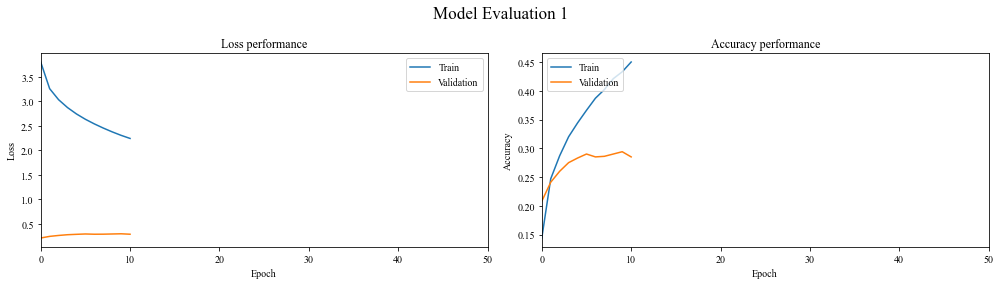

In [28]:
#I. Get predictions in integers
predictions_model1=get_predictions(model1) 
#II. Convert loaded history dictionary into dataframe
df_model1=history_transformation(loaded_dict_model1)
#III. Plot evolution of model training process
plot_stage_accuracy(df_model1,'Model Evaluation 1')

In [29]:
# IV. What was the highest level of accuracy in the validation dataset
validation_model1_result=df_model1['Validation_Accuracy'].to_list()[-1]
validation_model1_result #Wil be used at the end - VALIDATION

0.285

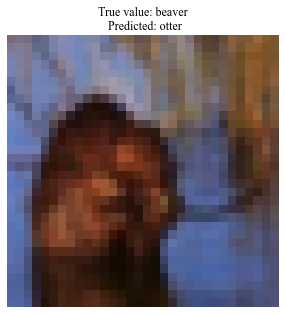

In [30]:
# V. Example of image result
image_result(50,predictions_modelx=predictions_model1)

In [31]:
# VI. Specific evaluation - For which categories are we doing a better job
specific_model1=specific_evaluation(y_validation=y_test,final_prediction=predictions_model1)
specific_model1.loc['beaver']
specific_model1

,precision,recall,f1-score,support
Label,,,,
sunflowers,0.69,0.56,0.62,100
plain,0.59,0.66,0.62,100
road,0.56,0.66,0.61,100
motorcycle,0.57,0.59,0.58,100
apple,0.49,0.66,0.56,100
...,...,...,...,...
lobster,0.22,0.04,0.07,100
man,0.15,0.04,0.06,100
beaver,0.14,0.04,0.06,100


In [32]:
# VII. Test results
test_model1=convertion_test_result(model1,1)
test_model1 #Will be used at the end - TEST

313/313 [==============================] - 1s 2ms/step - loss: 1.9615 - accuracy: 0.1807


,Loss,Accuracy
Approach,,
1.0,1.9615,0.1807


### II. Model 2: Additional Hidden Layer

In [33]:
# start_time = time.time()

# # Seed
# reset_random_seeds()

# #Architecture
# model2=Sequential([
#     #Convolutional
#     layers.Conv2D(10,2,padding='same',activation='relu'),
#     layers.MaxPooling2D(),
#     #Regular
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'), #Addition (128 is arbitrary)
#     layers.Dense(100,activation='softmax')    
# ])
# #Compile
# model2.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])
# #Training
# history_model2=model2.fit(X_train, Y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE,
#           verbose=VERBOSE,validation_data=[X_val,Y_val],callbacks=[stop_early,rlrop],workers=6, use_multiprocessing=True)

# #Timing
# end_time = time.time()
# model2_time = end_time - start_time

In [34]:
#Save model
# model2.save('model2.h5')
#Loading: To avoid having to train from scratch
from keras.models import load_model
model2 = keras.models.load_model('model2.h5')

In [35]:
%%capture
import pickle 

# with open('saved_dictionary_model2.pkl', 'wb') as f: #Save history results
#      pickle.dump(history_model2, f)
        
with open('saved_dictionary_model2.pkl', 'rb') as f: #Load results
    loaded_dict_model2 = pickle.load(f);

In [36]:
#Save time it took using CPU
#Write the variable to the file
# with open("model2_time.txt", "w") as f:
#     f.write(str(model2_time))
#Read the variable
with open("model2_time.txt", "r") as f:
    model2_time = f.read()
model2_time

'102.5689902305603'

##### Results Model 2

313/313 [==============================] - 1s 2ms/step


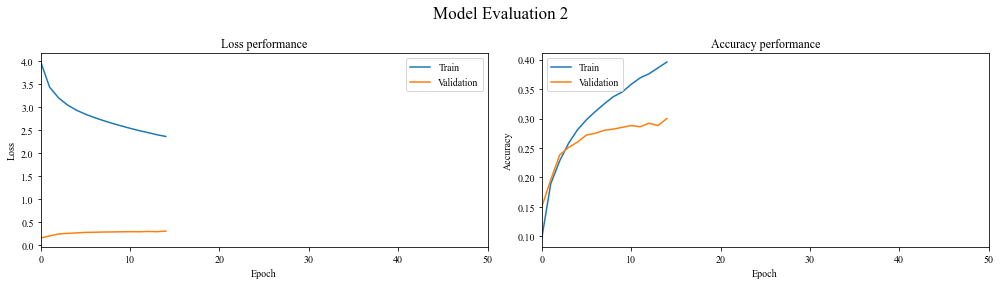

In [37]:
#I. Get predictions in integers
predictions_model2=get_predictions(model2) 
#II. Convert loaded history dictionary into dataframe
df_model2=history_transformation(loaded_dict_model2)
#III. Plot evolution of model training process
plot_stage_accuracy(df_model2,'Model Evaluation 2')

In [38]:
# IV. What was the highest level of accuracy in the validation dataset
validation_model2_result=df_model2['Validation_Accuracy'].to_list()[-1]
validation_model2_result #Wil be used at the end - VALIDATION

0.3

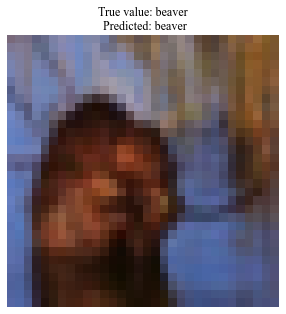

In [39]:
# V. Example of image result
image_result(50,predictions_modelx=predictions_model2)

In [40]:
# VI. Specific evaluation - For which categories are we doing a better job
specific_model2=specific_evaluation(y_validation=y_test,final_prediction=predictions_model2)
specific_model2.loc['beaver']
specific_model2

,precision,recall,f1-score,support
Label,,,,
apple,0.61,0.57,0.59,100
road,0.65,0.54,0.59,100
sunflowers,0.59,0.53,0.56,100
skyscraper,0.62,0.50,0.55,100
oak,0.47,0.65,0.54,100
...,...,...,...,...
seal,0.16,0.05,0.08,100
rabbit,0.14,0.05,0.07,100
table,0.12,0.04,0.06,100


In [41]:
# VII. Test results
test_model2=convertion_test_result(model2,2)
test_model2 #Will be used at the end - TEST

313/313 [==============================] - 1s 3ms/step - loss: 1.8703 - accuracy: 0.1842


,Loss,Accuracy
Approach,,
2.0,1.8703,0.1842


### III. Model 3: Extra hidden and convolutional layers

In [42]:
# start_time = time.time()

# # Seed
# reset_random_seeds()

# #Architecture
# model3=Sequential([
#     #Convolutional
#     layers.Conv2D(10,2,padding='same',activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(20,2,padding='same',activation='relu'),#One more Layer for convolutional
#     layers.MaxPooling2D(),
#     #Regular
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'), 
#     layers.Dense(64, activation='relu'), #Addition (64 is arbitrary)
#     layers.Dense(100,activation='softmax')    
# ])
# #Compile
# model3.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])
# #Training
# history_model3=model3.fit(X_train, Y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE,
#           verbose=VERBOSE,validation_data=[X_val,Y_val],callbacks=[stop_early,rlrop],workers=6, use_multiprocessing=True)
# #Timing
# end_time = time.time()
# model3_time = end_time - start_time

In [43]:
# Save model
# model3.save('model3.h5')
# Loading: To avoid having to train from scratch
from keras.models import load_model
model3 = keras.models.load_model('model3.h5')

In [44]:
%%capture
import pickle 

# with open('saved_dictionary_model3.pkl', 'wb') as f: #Save history results
#      pickle.dump(history_model3, f)
        
with open('saved_dictionary_model3.pkl', 'rb') as f: #Load results
    loaded_dict_model3 = pickle.load(f)

In [45]:
#Save time it took using CPU
#Write the variable to the file
# with open("model3_time.txt", "w") as f:
#     f.write(str(model3_time))
#Read the variable
with open("model3_time.txt", "r") as f:
    model3_time = f.read()
model3_time

'177.21929144859314'

##### Results Model 3

313/313 [==============================] - 1s 3ms/step


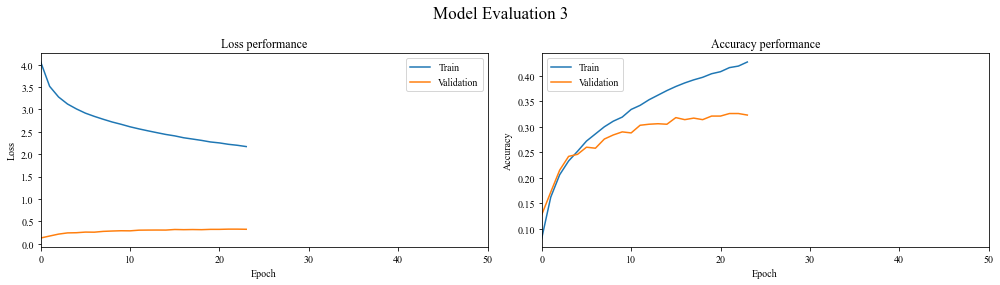

In [46]:
#I. Get predictions in integers
predictions_model3=get_predictions(model3) 
#II. Convert loaded history dictionary into dataframe
df_model3=history_transformation(loaded_dict_model3)
#III. Plot evolution of model training process
plot_stage_accuracy(df_model3,'Model Evaluation 3')

In [47]:
# IV. What was the highest level of accuracy in the validation dataset
validation_model3_result=df_model3['Validation_Accuracy'].to_list()[-1]
validation_model3_result #Wil be used at the end - VALIDATION

0.323

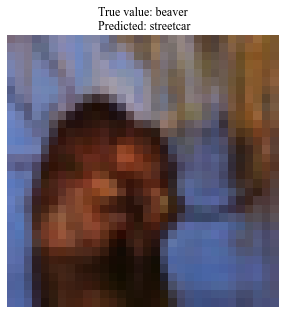

In [48]:
# V. Example of image result
image_result(50,predictions_modelx=predictions_model3)

In [49]:
# VI. Specific evaluation - For which categories are we doing a better job
specific_model3=specific_evaluation(y_validation=y_test,final_prediction=predictions_model3)
specific_model3.loc['beaver']
specific_model3

,precision,recall,f1-score,support
Label,,,,
plain,0.68,0.64,0.66,100
road,0.62,0.69,0.65,100
sunflowers,0.53,0.69,0.60,100
lawn-mower,0.50,0.67,0.57,100
apple,0.73,0.46,0.56,100
...,...,...,...,...
squirrel,0.14,0.08,0.10,100
seal,0.18,0.06,0.09,100
mouse,0.19,0.05,0.08,100


In [50]:
# VII. Test results
test_model3=convertion_test_result(model3,3)
test_model3 #Will be used at the end - TEST

313/313 [==============================] - 1s 3ms/step - loss: 1.7662 - accuracy: 0.2059


,Loss,Accuracy
Approach,,
3.0,1.7662,0.2059


### IV. Model 4: Drop out

In [51]:
# start_time = time.time()

# # Seed
# reset_random_seeds()

# #Architecture
# model4=Sequential([
#     #Convolutional
#     layers.Conv2D(10,2,padding='same',activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(20,2,padding='same',activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2), #Layer of dropout
#     #Regular
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.2), #Layer of dropout
#     layers.Dense(64, activation='relu'), 
#     layers.Dense(100,activation='softmax')    
# ])
# #Compile
# model4.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])
# #Training
# history_model4=model4.fit(X_train, Y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE,
#           verbose=VERBOSE,validation_data=[X_val,Y_val],callbacks=[stop_early,rlrop],workers=6,use_multiprocessing=True)
# #Timing
# end_time = time.time()
# model4_time = end_time - start_time

In [52]:
#Save model
# model4.save('model4.h5')
#Loading: To avoid having to train from scratch
from keras.models import load_model
model4 = keras.models.load_model('model4.h5')

In [53]:
%%capture
import pickle 

# with open('saved_dictionary_model4.pkl', 'wb') as f: #Save history results
#      pickle.dump(history_model4, f)
        
with open('saved_dictionary_model4.pkl', 'rb') as f: #Load results
    loaded_dict_model4 = pickle.load(f);

In [54]:
#Save time it took using CPU
#Write the variable to the file
# with open("model4_time.txt", "w") as f:
#     f.write(str(model4_time))
# Read the variable
with open("model4_time.txt", "r") as f:
    model4_time = f.read()
model4_time

'262.86408734321594'

##### Results Model 4

313/313 [==============================] - 1s 3ms/step


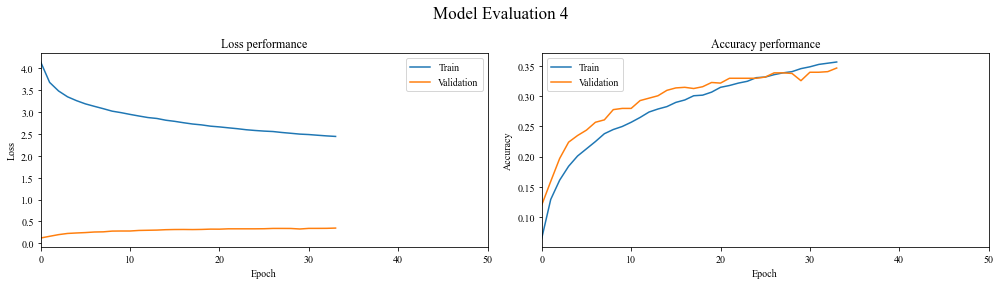

In [55]:
#I. Get predictions in integers
predictions_model4=get_predictions(model4) 
#II. Convert loaded history dictionary into dataframe
df_model4=history_transformation(loaded_dict_model4)
#III. Plot evolution of model training process
plot_stage_accuracy(df_model4,'Model Evaluation 4')

In [56]:
# IV. What was the highest level of accuracy in the validation dataset
validation_model4_result=df_model4['Validation_Accuracy'].to_list()[-1]
validation_model4_result #Wil be used at the end - VALIDATION

0.347

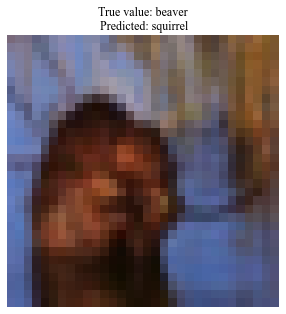

In [57]:
# V. Example of image result
image_result(50,predictions_modelx=predictions_model4)

In [58]:
# VI. Specific evaluation - For which categories are we doing a better job
specific_model4=specific_evaluation(y_validation=y_test,final_prediction=predictions_model4)
specific_model4.loc['beaver']
specific_model4

,precision,recall,f1-score,support
Label,,,,
plain,0.61,0.69,0.65,100
sunflowers,0.59,0.71,0.64,100
lawn-mower,0.61,0.65,0.63,100
road,0.56,0.67,0.61,100
motorcycle,0.48,0.80,0.60,100
...,...,...,...,...
woman,0.16,0.09,0.11,100
snail,0.29,0.05,0.09,100
possum,0.11,0.07,0.09,100


In [59]:
# VII. Test results
test_model4=convertion_test_result(model4,4)
test_model4 #Will be used at the end - TEST

313/313 [==============================] - 1s 3ms/step - loss: 1.6697 - accuracy: 0.2154


,Loss,Accuracy
Approach,,
4.0,1.6697,0.2154


### V. Model 5: Data Augmentation

In [60]:
#Creation of instance of augmentation
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR) #To avoid warning in tensorflow and just error messages
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(32,32,3)), #RandomFlip
    layers.experimental.preprocessing.RandomFlip('vertical'),
    layers.experimental.preprocessing.RandomRotation(0.1) #Rotation
  ])

In [61]:
# start_time = time.time()

# # Seed
# reset_random_seeds()

# #Architecture
# model5=Sequential([data_augmentation, #Add layer
#     #Convolutional
#     layers.Conv2D(10,2,padding='same',activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(20,2,padding='same',activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2), 
#     #Regular
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.2), 
#     layers.Dense(64, activation='relu'), 
#     layers.Dense(100,activation='softmax')    
# ])
# #Compile
# model5.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])
# #Training
# history_model5=model5.fit(X_train, Y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE,
#           verbose=VERBOSE,validation_data=[X_val,Y_val],callbacks=[stop_early,rlrop],workers=6,use_multiprocessing=True)
# #Timing
# end_time = time.time()
# model5_time = end_time - start_time

In [62]:
# #Save model
#model5.save('model5.h5')
# Loading: To avoid having to train from scratch
from keras.models import load_model
model5 = keras.models.load_model('model5.h5')

In [63]:
%%capture
import pickle 

# with open('saved_dictionary_model5.pkl', 'wb') as f: #Save history results
#      pickle.dump(history_model5, f)
        
with open('saved_dictionary_model5.pkl', 'rb') as f: #Load results
    loaded_dict_model5 = pickle.load(f);

In [64]:
#Save time it took using CPU
#Write the variable to the file
# with open("model5_time.txt", "w") as f:
#     f.write(str(model5_time))
# Read the variable
with open("model5_time.txt", "r") as f:
    model5_time = f.read()
model5_time

'205.13554310798645'

##### Results Model 5

313/313 [==============================] - 1s 3ms/step


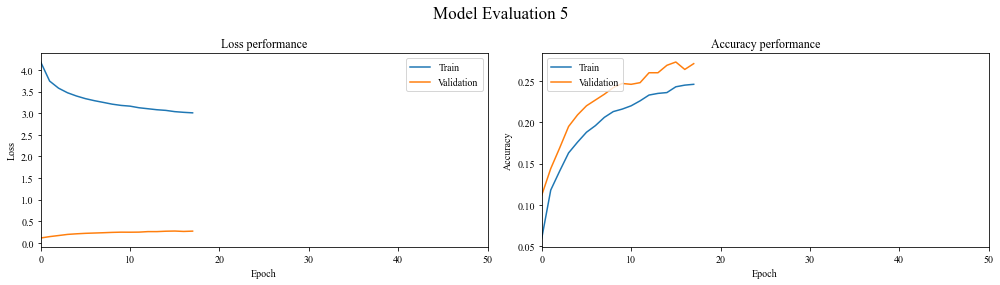

In [65]:
#I. Get predictions in integers
predictions_model5=get_predictions(model5) 
#II. Convert loaded history dictionary into dataframe
df_model5=history_transformation(loaded_dict_model5)
#III. Plot evolution of model training process
plot_stage_accuracy(df_model5,'Model Evaluation 5')

In [66]:
# IV. What was the highest level of accuracy in the validation dataset
validation_model5_result=df_model5['Validation_Accuracy'].to_list()[-1]
validation_model5_result #Wil be used at the end - VALIDATION

0.271

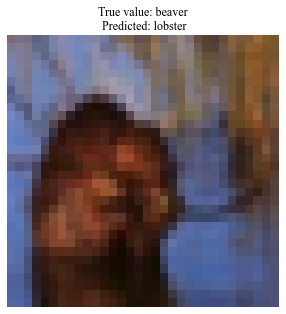

In [67]:
# V. Example of image result
image_result(50,predictions_modelx=predictions_model5)

In [68]:
# VI. Specific evaluation - For which categories are we doing a better job
specific_model5=specific_evaluation(y_validation=y_test,final_prediction=predictions_model5)
specific_model5.loc['beaver']
specific_model5

,precision,recall,f1-score,support
Label,,,,
road,0.62,0.64,0.63,100
plain,0.61,0.66,0.63,100
oak,0.52,0.70,0.60,100
sunflowers,0.47,0.70,0.56,100
skyscraper,0.69,0.43,0.53,100
...,...,...,...,...
snake,0.08,0.04,0.05,100
otter,0.17,0.02,0.04,100
rabbit,0.11,0.02,0.03,100


In [69]:
# VII. Test results
test_model5=convertion_test_result(model5,5)
test_model5 #Will be used at the end - TEST

313/313 [==============================] - 1s 3ms/step - loss: 2.9002 - accuracy: 0.2710


,Loss,Accuracy
Approach,,
5.0,2.9002,0.271


### VI. Model 6: Transfer Learning

##### MobileNet

In [70]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from keras.layers import Conv2D

# Load the MobileNet model with pre-trained ImageNet weights, exclude the top layer
input_shape = (32, 32, 3)
base_model = MobileNet(include_top=False, input_shape=input_shape)


# Add classification layers on top of the base MobileNet model
x = base_model.output
x = Conv2D(10,2,padding='same',activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) #This is what we can improve with HYPERPARAMETER OPTIMIZATION

#     layers.MaxPooling2D(),
predictions = Dense(100, activation='softmax')(x)

In [71]:
# start_time = time.time()
# stop_early2=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True,verbose=1,mode='min') 

# # Seed
# reset_random_seeds()

# #Architecture
# # Combine the base MobileNet model with the classification layers
# model6 = Model(inputs=base_model.input, outputs=predictions)

# #Compile
# model6.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])
# #Training
# history_model6=model6.fit(X_train, Y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE,
#           verbose=VERBOSE,validation_data=[X_val,Y_val],callbacks=[stop_early2,rlrop],workers=6,use_multiprocessing=True)
# #Timing
# end_time = time.time()
# model6_time = end_time - start_time

In [72]:
# # # #Save model
# model6.save('model6.h5')
# #Loading: To avoid having to train from scratch
from keras.models import load_model
model6= keras.models.load_model('model6.h5')

In [73]:
%%capture
# import pickle 

# with open('saved_dictionary_model6.pkl', 'wb') as f: #Save history results
#      pickle.dump(history_model6, f)
        
# df_model6=history_transformation(history_model6)
# df_model6.to_csv('history_trainingm6.csv')

In [74]:
# #Save time it took using CPU
# #Write the variable to the file
# with open("model6_time.txt", "w") as f:
#     f.write(str(model6_time))
#Read the variable
with open("model6_time.txt", "r") as f:
    model6_time = f.read()
model6_time

'2676.8279247283936'

##### Results Model 6

313/313 [==============================] - 6s 16ms/step


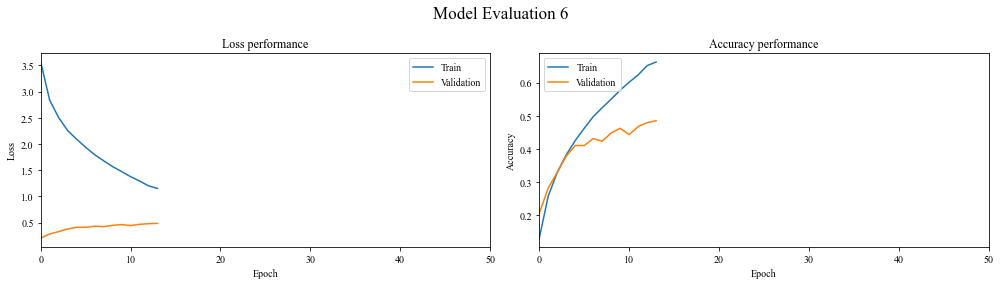

In [75]:
#I. Get predictions in integers
predictions_model6=get_predictions(model6) 
#II. Load df of dictionary
df_model6=pd.read_csv('history_trainingm6.csv')
#III. Plot evolution of model training process
plot_stage_accuracy(df_model6,'Model Evaluation 6')

In [76]:
# IV. What was the highest level of accuracy in the validation dataset
validation_model6_result=df_model6['Validation_Accuracy'].to_list()[-1]
validation_model6_result #Wil be used at the end - VALIDATION

0.485

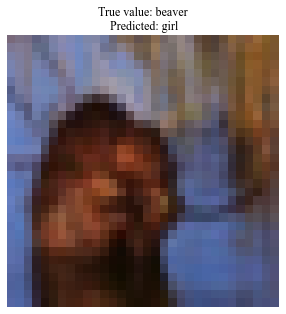

In [77]:
# V. Example of image result
image_result(50,predictions_modelx=predictions_model6)

In [78]:
# VI. Specific evaluation - For which categories are we doing a better job
specific_model6=specific_evaluation(y_validation=y_test,final_prediction=predictions_model6)
specific_model6.loc['beaver']
specific_model6

,precision,recall,f1-score,support
Label,,,,
road,0.80,0.82,0.81,100
skyscraper,0.78,0.76,0.77,100
sunflowers,0.72,0.78,0.75,100
chair,0.90,0.64,0.75,100
wardrobe,0.65,0.86,0.74,100
...,...,...,...,...
boy,0.35,0.09,0.14,100
beaver,0.33,0.06,0.10,100
otter,0.17,0.04,0.06,100


In [79]:
# VII. Test results
test_model6=convertion_test_result(model6,6)
test_model6 #Will be used at the end - TEST

313/313 [==============================] - 5s 15ms/step - loss: 2.0688 - accuracy: 0.4627


,Loss,Accuracy
Approach,,
6.0,2.0688,0.4627


### VI. Model 7: HyperParameter Optimization

##### Random Search

In [80]:
#Required libraries
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import randint, uniform
from scipy.stats import randint as sp_randint
from keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip

#Define the function
def create_model(neurons=256, optimizer=Adam, learning_rate=0.001, num_hidden_layers=1, dropout_rate=0.2,n_filters=10,
                n_kernel=2):
    input_shape = (32, 32, 3)
    base_model = MobileNet(include_top=False, input_shape=input_shape)

    # Combine base model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs)
    x = Conv2D(n_filters,n_kernel,padding='same',activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    for i in range(num_hidden_layers):
        x = Dense(neurons, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
    predictions = Dense(100, activation='softmax')(x)

    # Create and compile the model
    model = keras.Model(inputs=inputs, outputs=predictions)
    optimizer = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create a KerasClassifier from the Keras model
keras_clf = KerasClassifier(build_fn=create_model)

# Define the parameter distribution for the randomized search
param_dist = {
    'neurons': sp_randint(64, 650),
    'optimizer': [Adam, SGD],
    'learning_rate': [0.001, 0.01, 0.0001],
    'num_hidden_layers': [1, 2, 3],
    'dropout_rate': uniform(0.1, 0.3),
    'n_filters': sp_randint(5,20),
    'n_kernel': sp_randint(2,5)
}

C:\Users\sergi\AppData\Local\Temp\ipykernel_16028\1288405543.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_clf = KerasClassifier(build_fn=create_model)


In [81]:
# start_time = time.time()

# reset_random_seeds()

# # Create a randomized search object with cross-validation
# random_search = RandomizedSearchCV(
#     estimator=keras_clf,
#     param_distributions=param_dist,
#     n_iter=30,
#     cv=3,
#     verbose=2, n_jobs=1
# )

# # Fit the RandomizedSearchCV object to the training data
# random_result = random_search.fit(X_train,Y_train,validation_data=(X_val, Y_val),callbacks=[stop_early,rlrop],
#                                  batch_size=250,epochs=20,verbose=1)

# # Print the best parameters and accuracy
# print("Best parameters found: ", random_result.best_params_)
# print("Best accuracy found: ", random_result.best_score_)

# end_time = time.time()
# time_model7 = end_time - start_time

In [82]:
# # Save result
# randomsearch_result=pd.DataFrame(random_result.cv_results_)
# randomsearch_result.to_excel('results2_randomsearch.xlsx')

In [83]:
# Read and explore result
randomsearch_result=pd.read_excel('results2_randomsearch.xlsx')
randomsearch_result.sort_values(by='rank_test_score').head(3)['params']

18    {'dropout_rate': 0.19397755852891407, 'learnin...
25    {'dropout_rate': 0.10307501181987727, 'learnin...
24    {'dropout_rate': 0.21917619861555238, 'learnin...
Name: params, dtype: object

In [84]:
# #Save time it took using CPU
# #Write the variable to the file
# with open("time_model7.txt", "w") as f:
#     f.write(str(time_model7))
#Read the variable
# with open("time_model7.txt", "r") as f:
#     time_model7 = f.read()
# time_model7

#### GridSearch

In [85]:
#Define the function
def create_model2(neurons=256, optimizer=Adam, learning_rate=0.001, num_hidden_layers=1, dropout_rate=0.2,n_filters=10,
                n_kernel=2):
    input_shape = (32, 32, 3)
    base_model = MobileNet(include_top=False, input_shape=input_shape)

    # Combine base model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs)
    x = Conv2D(n_filters,n_kernel,padding='same',activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    for i in range(num_hidden_layers):
        x = Dense(neurons, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
    predictions = Dense(100, activation='softmax')(x)

    # Create and compile the model
    model = keras.Model(inputs=inputs, outputs=predictions)
    optimizer = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create a KerasClassifier from the Keras model
keras_clf2 = KerasClassifier(build_fn=create_model2)

# Define the parameter distribution for the randomized search
param_dist2 = {
    'neurons': [125,550],
    'optimizer': [Adam],
    'learning_rate': [0.001],
    'num_hidden_layers': [3],
    'dropout_rate': [0.1,0.2],
    'n_filters': [7,13,17],
    'n_kernel': [2,4]
}

C:\Users\sergi\AppData\Local\Temp\ipykernel_16028\1162867324.py:27: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_clf2 = KerasClassifier(build_fn=create_model2)


In [86]:
# from sklearn.model_selection import GridSearchCV
# start_time = time.time()

# reset_random_seeds()

# # GridSearch
# grid_model7 = GridSearchCV(estimator=keras_clf2, 
#                            param_grid=param_dist2, 
#                            cv=2,verbose=2,
#                            n_jobs=1)

# history_7grid_finalxd = grid_model7.fit(X_train,Y_train, validation_data=(X_val,Y_val),callbacks=[stop_early,rlrop],
#                                        batch_size=200,epochs=50,verbose=1)

# end_time = time.time()
# time_model7_gridsearch = end_time - start_time

In [87]:
# #Save results
# gridsearch_result=pd.DataFrame(history_7grid_finalxd.cv_results_)
# gridsearch_result.to_excel('results2_gridsearch.xlsx')

In [88]:
# Read and explore result
gridsearch_result=pd.read_excel('results2_gridsearch.xlsx')
gridsearch_result.sort_values(by='rank_test_score').head(3)['params']

4     {'dropout_rate': 0.1, 'learning_rate': 0.001, ...
9     {'dropout_rate': 0.1, 'learning_rate': 0.001, ...
21    {'dropout_rate': 0.2, 'learning_rate': 0.001, ...
Name: params, dtype: object

In [89]:
# #Save time it took using CPU
# #Write the variable to the file
# with open("time_model7_gridsearch.txt", "w") as f:
#     f.write(str(time_model7_gridsearch))
#Read the variable
with open("time_model7_gridsearch.txt", "r") as f:
    time_model7_gridsearch = f.read()
time_model7_gridsearch

'51027.217200517654'

# Final Model

In [90]:
#Define the function
def create_model(neurons=256, optimizer=Adam, learning_rate=0.001, num_hidden_layers=1, dropout_rate=0.2,n_filters=10,
                n_kernel=2):
    input_shape = (32, 32, 3)
    base_model = MobileNet(include_top=False, input_shape=input_shape)

    # Combine base model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs)
    x = Conv2D(n_filters,n_kernel,padding='same',activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    for i in range(num_hidden_layers):
        x = Dense(neurons, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
    predictions = Dense(100, activation='softmax')(x)

    # Create and compile the model
    model = keras.Model(inputs=inputs, outputs=predictions)
    optimizer = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model



In [91]:
# start_time = time.time()
# stop_early2=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,restore_best_weights=True,verbose=1,mode='min') 
# # Seed
# reset_random_seeds()

# # Using those parameters create and retrain the model
# final_model=create_model(neurons=125,optimizer=Adam,learning_rate=0.001,num_hidden_layers=3,
#                          dropout_rate=0.1,n_filters=13,n_kernel=2)

# # Be aware of the sligh change in the name
# model7_history = final_model.fit(x_train,y_train, epochs=100, batch_size=40,
#                                   verbose=VERBOSE, callbacks=[stop_early2],workers=6, use_multiprocessing=True)

# #Track time
# end_time = time.time()
# final_training = end_time - start_time

In [92]:
# #Save model
# final_model.save('final_model.h5')
# #Loading: To avoid having to train from scratch
from keras.models import load_model
final_model = keras.models.load_model('final_model.h5')

In [93]:
%%capture
# # import pickle 
# with open('saved_dictionary_model7.pkl', 'wb') as f: #Save history results
#      pickle.dump(model7_history, f)
        
# df_model7=history_transformation(model7_history)
# df_model7.to_csv('history_trainingm7.csv')

In [94]:
# #Save time it took using CPU
# # #Write the variable to the file
# with open("model7_time.txt", "w") as f:
#     f.write(str(final_training))
#Read the variable
with open("model7_time.txt", "r") as f:
    model7_time = f.read()
model7_time

'30670.88341999054'

##### Results Model 7

313/313 [==============================] - 5s 16ms/step


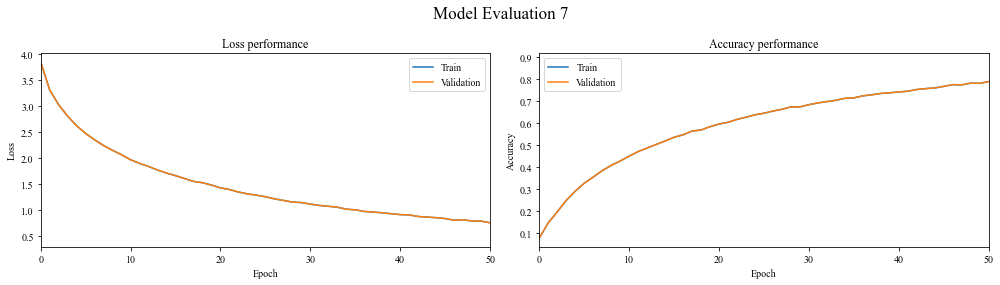

In [95]:
#I. Get predictions in integers
predictions_model7=get_predictions(final_model) 
#II. Load df of dictionary
df_model7=pd.read_csv('history_trainingm7.csv')
#III. Plot evolution of model training process
plot_stage_accuracy2(df_model7,'Model Evaluation 7')

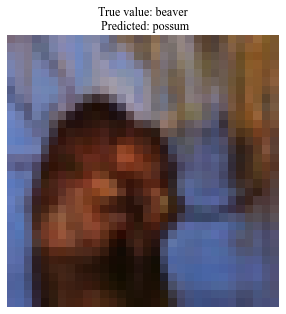

In [96]:
# V. Example of image result
image_result(50,predictions_modelx=predictions_model7)

In [97]:
# VI. Specific evaluation - For which categories are we doing a better job
specific_model7=specific_evaluation(y_validation=y_test,final_prediction=predictions_model7)
specific_model7.loc['beaver']
specific_model7.tail(5)

,precision,recall,f1-score,support
Label,,,,
turtle,0.17,0.21,0.19,100
lizard,0.15,0.26,0.19,100
possum,0.14,0.29,0.19,100
bear,0.17,0.17,0.17,100
squirrel,0.24,0.12,0.16,100


In [98]:
# VII. Test results
test_model7=convertion_test_result(final_model,7)
test_model7 #Will be used at the end - TEST

313/313 [==============================] - 6s 16ms/step - loss: 2.8280 - accuracy: 0.5040


,Loss,Accuracy
Approach,,
7.0,2.828,0.504


In [99]:
def image_result3(indices,title,predictions_modelx=[predictions_model1,predictions_model2,predictions_model3,predictions_model4,
                                    predictions_model5,predictions_model6,predictions_model7],filename=None):
    fig, axs = plt.subplots(1,7 , figsize=(15, 5))
    fig.suptitle(title,y=0.85,fontsize=25)
    for i, prediction in enumerate(predictions_modelx):
        axs[i].axis('off')
        axs[i].imshow(x_test[indices])
        axs[i].set_title('Model '+str(i+1) +'\n True value: ' + str(class_list[y_test_reshaped[indices]]) + '\n Predicted: ' + str(class_list[prediction[indices]]))
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

# Superclasses

#### 1. Initial model

In [100]:
# start_time = time.time()

# stop_early3=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=4,restore_best_weights=True,verbose=1,mode='min') 

# # Seed
# reset_random_seeds()

# #Architecture
# super1=Sequential([
#     #Convolutional
#     layers.Conv2D(10,2,padding='same',activation='relu'),
#     layers.MaxPooling2D(),
#     #Regular
#     layers.Flatten(),
#     layers.Dense(20,activation='softmax')    
# ])
# #Compile
# super1.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])
# #Training
# time_super1=super1.fit(x_train,y_train_sup,epochs=N_EPOCH, batch_size=BATCH_SIZE,
#           verbose=VERBOSE,callbacks=[stop_early3],workers=6, use_multiprocessing=True)
# #Timing
# end_time = time.time()
# super1_time = end_time - start_time

In [101]:
# #Save model
# super1.save('super1.h5')
# #Loading: To avoid having to train from scratch
from keras.models import load_model
super1 = keras.models.load_model('super1.h5')

In [102]:
# VII. Test results
super_test_model1=convertion_test_result2(super1,1)
super_test_model1 #Will be used at the end - TEST

313/313 [==============================] - 1s 2ms/step - loss: 2.0566 - accuracy: 0.3765


,Loss,Accuracy
Approach,,
1.0,2.0566,0.3765


In [103]:
predictions_modelsup1=get_predictions(super1)
specific_evaluation2(y_validation=y_test_sup,final_prediction=predictions_modelsup1)

313/313 [==============================] - 1s 2ms/step


,precision,recall,f1-score,support
Label,,,,
trees,0.65,0.67,0.66,500
flowers,0.57,0.52,0.55,500
large natural outdoor scenes,0.49,0.54,0.52,500
large man-made outdoor things,0.40,0.55,0.46,500
fruit and vegetables,0.38,0.54,0.45,500
people,0.41,0.51,0.45,500
food containers,0.52,0.35,0.42,500
vehicles 1,0.51,0.36,0.42,500
vehicles 2,0.36,0.39,0.37,500


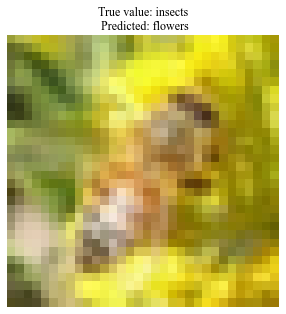

In [104]:
image_result2(200,predictions_modelsup1)

#### 2. Final model

In [105]:
# start_time = time.time()
# stop_early2=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=4,restore_best_weights=True,verbose=1,mode='min') 
# # Seed
# reset_random_seeds()

# # Using those parameters create and retrain the model
# super3=create_model_sup(neurons=125,optimizer=Adam,learning_rate=0.001,num_hidden_layers=3,
#                          dropout_rate=0.1,n_filters=13,n_kernel=2)

# # Be aware of the sligh change in the name
# time_super3 = super3.fit(x_train,y_train_sup, epochs=N_EPOCH, batch_size=BATCH_SIZE,
#                                   verbose=VERBOSE, callbacks=[stop_early2],workers=6, use_multiprocessing=True)

# #Track time
# end_time = time.time()
# final_training = end_time - start_time

In [106]:
# #Save model
# super3.save('super3.h5')
#Loading: To avoid having to train from scratch
from keras.models import load_model
super3 = keras.models.load_model('super3.h5')

In [107]:
# VII. Test results
super_test_model7=convertion_test_result2(super3,7)
super_test_model7 #Will be used at the end - TEST

313/313 [==============================] - 5s 15ms/step - loss: 1.5537 - accuracy: 0.6564


,Loss,Accuracy
Approach,,
7.0,1.5537,0.6564


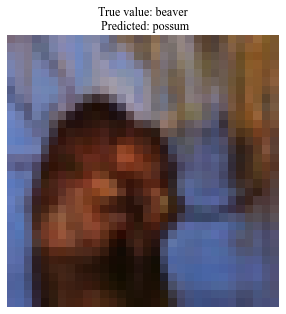

In [108]:
image_result(50,predictions_modelx=predictions_model7)

In [109]:
predictions_modelsup3=get_predictions(super3)
specific_evaluation2(y_validation=y_test_sup,final_prediction=predictions_modelsup3)

313/313 [==============================] - 5s 15ms/step


,precision,recall,f1-score,support
Label,,,,
trees,0.87,0.91,0.89,500
large natural outdoor scenes,0.83,0.79,0.81,500
flowers,0.80,0.77,0.79,500
large man-made outdoor things,0.80,0.79,0.79,500
vehicles 1,0.77,0.75,0.76,500
people,0.81,0.68,0.74,500
household furniture,0.75,0.73,0.74,500
food containers,0.81,0.60,0.69,500
fruit and vegetables,0.59,0.82,0.69,500


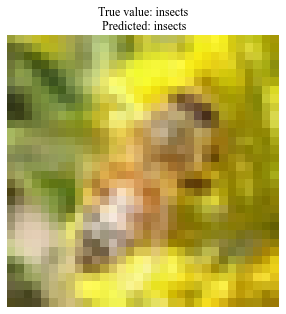

In [110]:
image_result2(200,predictions_modelsup3)

## Final Comparison

#### 100 classes

In [111]:
final_comparison=pd.concat([test_model1,test_model2,test_model3,test_model4,test_model5,test_model6,test_model7])
final_comparison.at[7, 'Accuracy'] = 0.595
final_comparison

,Loss,Accuracy
Approach,,
1.0,1.9615,0.1807
2.0,1.8703,0.1842
3.0,1.7662,0.2059
4.0,1.6697,0.2154
5.0,2.9002,0.2710
6.0,2.0688,0.4627
7.0,2.8280,0.5950


C:\Users\sergi\AppData\Local\Temp\ipykernel_16028\16591957.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('accuracy_evolution.jpg', dpi=300, quality=100)


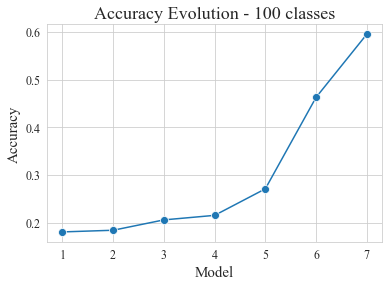

In [112]:
# Create the lineplot using Seaborn
sns.set_style("whitegrid")
plt.rc('font', family='Times New Roman')
sns.lineplot(data=final_comparison['Accuracy'], marker='o',markersize=8)
plt.xlabel('Model',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title('Accuracy Evolution - 100 classes',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('accuracy_evolution.jpg', dpi=300, quality=100)
plt.show()

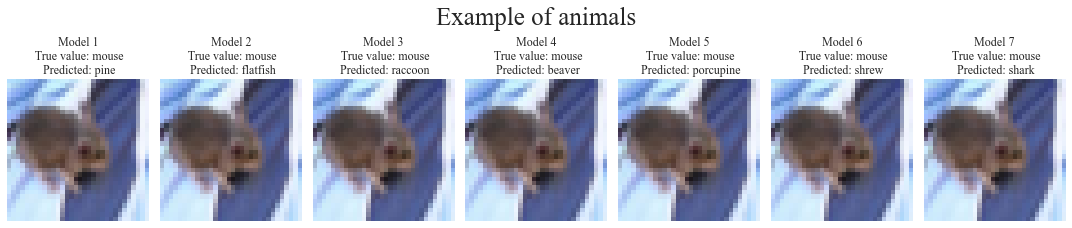

In [113]:
image_result3(96,'Example of animals',filename='Animals.jpg')

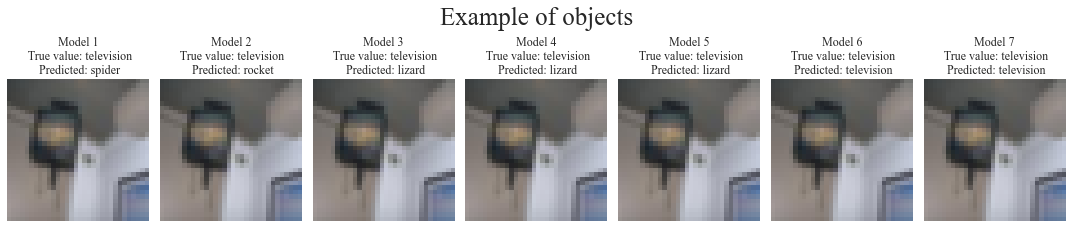

In [114]:
image_result3(162,'Example of objects',filename='Objects.jpg')

### For super classes

In [115]:
final_comparison_sup=pd.concat([super_test_model1,super_test_model7])
final_comparison_sup

,Loss,Accuracy
Approach,,
1.0,2.0566,0.3765
7.0,1.5537,0.6564


C:\Users\sergi\AppData\Local\Temp\ipykernel_16028\2107464709.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('accuracy_evolution_supper.jpg', dpi=300, quality=100)


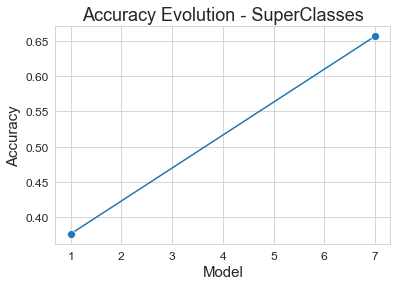

In [116]:
# Create the lineplot using Seaborn
sns.set_style("whitegrid")
sns.lineplot(data=final_comparison_sup['Accuracy'], marker='o',markersize=8)
plt.xlabel('Model',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title('Accuracy Evolution - SuperClasses',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('accuracy_evolution_supper.jpg', dpi=300, quality=100)
plt.show()

C:\Users\sergi\AppData\Local\Temp\ipykernel_16028\2411292169.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('confuxionmatrix.jpg', dpi=400, quality=100,bbox_inches='tight')


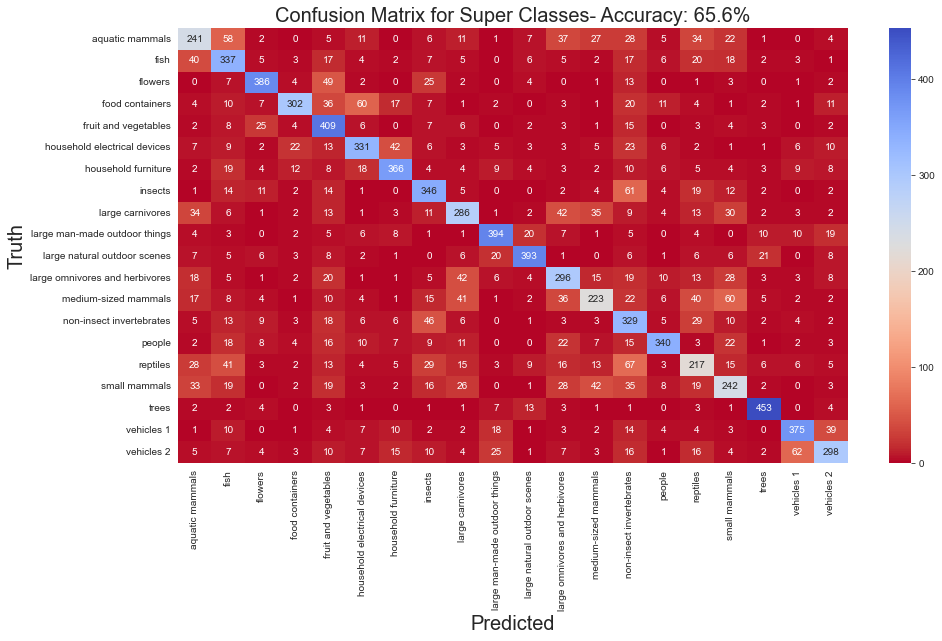

In [117]:
#Confusion matrix
confusion_matrix2=confusion_matrix(y_test_sup,predictions_modelsup3)
plt.figure(figsize=(15,8))
ax=sns.heatmap(confusion_matrix2,
            cmap="coolwarm_r", 
            annot=True,#True is to have the values
            fmt=".0f") #To avoid scientific notation
ax.xaxis.set_ticklabels(list_superclasses) #To add labels to easier interpretation
ax.yaxis.set_ticklabels(list_superclasses)
plt.xlabel('Predicted',size=20)
for label in ax.yaxis.get_ticklabels():
    label.set_rotation(0)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
plt.ylabel('Truth',size=20)
plt.title('Confusion Matrix for Super Classes- Accuracy: 65.6%',size=20)
plt.savefig('confuxionmatrix.jpg', dpi=400, quality=100,bbox_inches='tight')
plt.show() #The confusiion matrix is very useful. We can notice that this model works better to categorize D but not too much to categorize B

## Spended time in training

In [118]:
time=[model1_time,model2_time,model3_time,model4_time,model5_time,model6_time,model7_time]
time.append('56300.45')
time.append('63402.41')
for i in range(len(time)):
    time[i] = float(time[i])/3600

In [119]:
time=pd.DataFrame(time,columns=['Time'])
time['Order']=[1,2,3,4,5,6,9,7,8]
time['Stage']=['Model 1','Model 2','Model 3','Model 4','Model 5','Model 6','Model 7','RandomSearch','GridSearch']
time=time.sort_values(by='Order')
time['Time']=time['Time'].round()
time=time.drop(['Order'], axis=1)
time=time.set_index('Stage')

C:\Users\sergi\AppData\Local\Temp\ipykernel_16028\3959855061.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('time.jpg', dpi=300, quality=100,bbox_inches='tight')


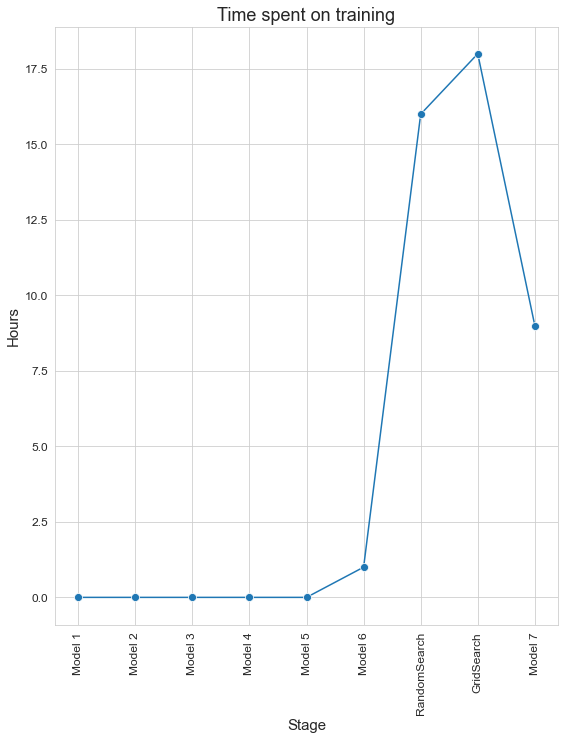

In [120]:
# Create the lineplot using Seaborn
sns.set_style("whitegrid")
fig = plt.figure(figsize=(9, 11))
sns.lineplot(data=time['Time'], marker='o',markersize=8)
plt.xlabel('Stage',fontsize=15)
plt.ylabel('Hours',fontsize=15)
plt.title('Time spent on training',fontsize=18)
plt.xticks(fontsize=12,rotation=90)
plt.yticks(fontsize=12)
plt.savefig('time.jpg', dpi=300, quality=100,bbox_inches='tight')
plt.show()


**Conclusions:** The final model built was significantly improved compared to the initial model. However, a precision of 59% is far from ideal and further improvements should be implemented. The major constraint in the construction of the model was time. Due to the impossibility of accessing GPUs, training was performed with CPUs, leading to very long waiting times (Figure X). Opting for a model other than MobileNet for the transfer would have been even more time-consuming. For this reason, the present work can be further improved by (i) exploring other, more optimal prior models for animal and image classification, (ii) expanding the range of possible hyperparameters, and (iii) accessing GPUs for faster and more efficient training.
